In [1]:
import os
from shutil import rmtree
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addAtomIndices=True
from tqdm import tqdm
import numpy as np
import pandas as pd

from serenityff.charge.tree.tree import Tree
from serenityff.charge.tree.atom_features import AtomFeatures
from serenityff.charge.tree_develop.tree_constructor import Tree_constructor

# Tree constructing

## Initializatrion

This notebook shows how to build a attention guided decision tree. To assign partial charges to the atoms of a molecule.
The building requires a sdf file with all the molecules and a csv file with all the attention data, generated with the `Extractor` class from `sereinityff`. Additionally, the user can provide certain options to the tree building process, like the ratio of building versus testing data. If the test data from the GNN training is still available, it can be used to test the tree, which is recommended for consistency.

In [2]:
data_file="../data/example_extraction.csv"
sdf_suply="../data/example.sdf" 
data_split = 0.2
out_folder = "./example_tree_out"
if os.path.exists(out_folder):
    rmtree(out_folder)
os.mkdir(out_folder)

All tools to build the tree are encapsulated in the `Tree_constructor` class. And we start by creating a instance of this class. Here we can also specify some additonal options, like how deep the tree should be build maximally (`num_layers=16`), if we want to sanitize the dataset and the verbosity level.

In [3]:
tree_constructor = Tree_constructor(df_path=data_file,
                sdf_suplier=sdf_suply,
                num_layers_to_build=16,
                data_split=data_split,
                verbose=True,
                sanitize=True,
                sanitize_charges=True)

2023-12-31 17:27:35.682312	Initializing Tree_constructor
2023-12-31 17:27:35.683751	Mols imported, starting df import
2023-12-31 17:27:35.695215	Sanitizing
2023-12-31 17:27:35.710485	Check charge sanity


100%|██████████| 20/20 [00:00<00:00, 2929.60it/s]

Number of wrong charged mols: 0 of 20 mols
2023-12-31 17:27:35.726876	df imported, starting data spliting
2023-12-31 17:27:35.727653	Splitting data
2023-12-31 17:27:35.729800	Data split, delete original
2023-12-31 17:27:35.754407	Starting table filling



100%|██████████| 334/334 [00:00<00:00, 2285.65it/s]

2023-12-31 17:27:35.907039	Table filled, starting adjacency matrix creation


Creating Adjacency matrices:


100%|██████████| 20/20 [00:00<00:00, 2032.03it/s]

Number of train mols: 16
Number of test mols: 4


The tree_constructor will initalize, sanize the data and then split the data into build and testset. The test set will not be used and can at the end be retrived to test the tree and meta parameters.  

## Atom Features

The next step is to create the zeroth layer of the tree. The zeroth atom is always the atom we try to assign a partial charge. Therefore the zeroth layer of the tree corresponds to a list of all atom features present in the dataset. A atom feature contains all relevand information of an atom, and will be the identifaction of every node in the tree. The atom features are stored in a helper class `AtomFeature` and offer some useful methods to compare and use atom features.

In [4]:
atom_feture_key = 12
AtomFeatures.lookup_int(12)

(6, 1, 0, True, 1)

A atom feature contains the following information:
 - Element type (e.g. C, N, O, ...)
 - Number of bonds (e.g. 1, 2, 3, ...)
 - Formal charge (e.g. -1, 0, 1, ...)
 - Hybridization (e.g. SP, SP2, SP3, ...)
 - Aromaticity (True or False)
 - Number of Hydrogens (e.g. 0, 1, 2, ...) (includeNeighbors=True)

These atom features are similar to the feature vector used in the GNN, but made more human readable. The atom features are stored in a dictionary, where the key is the atom index and the value is the atom feature.
During the tree building process we will build subgraphs for each atom in the dataset, guided by the attention values. The start of the subgraph is the zeroth atom itself. The subgraph will be build by adding the neighbors of the zeroth atom to the subgraph. The neighbors are selected by the attention values. Nodes of layers deeper than the zeroth layer will have the atom feature of the atom and the way it is connected to the current subgraph. For example `[12, 0, 1]` would mean that the atom with atom feature 12 is connected to atom 0 of the current subgraph with a single bond.

Atom features can be generated directly from rdkit molecules, and the class offers multiple tools to experiment with atom features.

Atom with idx:0 has AtomFeature: (6, 4, 0, False, 3)


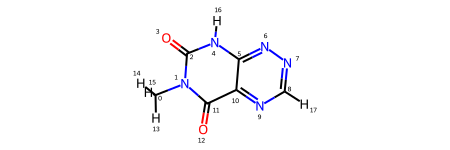

In [5]:
atom_idx_in_mol = 0
mol = Chem.SDMolSupplier(sdf_suply, removeHs=False)[0]
[mol.ClearProp(prop) for prop in mol.GetPropNames()]
atom_feture_key = AtomFeatures.atom_features_from_molecule(mol, 0)
print(f"Atom with idx:{atom_idx_in_mol} has AtomFeature: {AtomFeatures.lookup_int(atom_feture_key)}")
mol

In [6]:
print(f"In the current version of serenityff there are {AtomFeatures.get_number_of_features()} atom features")

In the current version of serenityff there are 122 atom features


If a molecule in the dataset would contain a atom with an atom feature that is not present in the dictionary, the tree could not be buid and needs to be added first. Therefore the tree can only assign partial charges to atoms with atom features in the set and will never extrapolate to new atom features.

## Building layers of the tree

The function `create_tree_level_0` will assign each atom in the dataset it's atom feature and create a branch conected to the root node of the tree for that atom feature with the data of all atoms belonging to that atom feature.

In [7]:
tree_constructor.create_tree_level_0()

Preparing Dataframe:
Creating Tree Level 0:


100%|██████████| 122/122 [00:00<00:00, 1766.41it/s]

2023-12-31 17:27:36.152220	Layer 0 done


Now we can also build all the other layers of the tree, by always adding the neighbours with the highest attention to the tree for all atoms in the dataset. Since this takes a lot of time, we provide a implementation parallelized with multiprocessing. The number of processes can be specified with the `num_processes` parameter. And each branch, of the tree, corresponding to the different zeroth level atom features will be build in independent processes.

In [8]:
tree_constructor.build_tree(num_processes=1)

AF=0 - Layer 1 done
children layer 1: []
AF 0 done
AF=1 - Layer 1 done
children layer 1: []
AF 1 done
AF=2 - Layer 1 done
children layer 1: []
AF 2 done
AF=3 - Layer 1 done
children layer 1: []
AF 3 done
AF=4 - Layer 1 done
children layer 1: []
AF 4 done
AF=5 - Layer 1 done
children layer 1: []
AF 5 done
AF=6 - Layer 1 done
children layer 1: [node --- lvl: 2, Num=1, Mean=0.0000, std=0.0000, fp=(6, 4, 0, False, 2) (0, 1)]
AF 6 done
AF=7 - Layer 1 done
children layer 1: []
AF 7 done
AF=8 - Layer 1 done
children layer 1: []
AF 8 done
AF=9 - Layer 1 done
children layer 1: []
AF 9 done
AF=10 - Layer 1 done
children layer 1: []
AF 10 done
AF=11 - Layer 1 done
children layer 1: []
AF 11 done
AF=12 - Layer 1 done
children layer 1: []
AF 12 done
AF=13 - Layer 1 done
children layer 1: []
AF 13 done
AF=14 - Layer 1 done
children layer 1: []
AF 14 done
AF=15 - Layer 1 done
children layer 1: []
AF 15 done
AF=16 - Layer 1 done
children layer 1: []
AF 16 done
AF=17 - Layer 1 done
children layer 1: []

In [9]:
print(tree_constructor.root.children[26])
print(tree_constructor.root.children[26].children)
print(tree_constructor.root.children[26].children[1].children)

node --- lvl: 1, Num=31, Mean=0.3128, std=0.3305, fp=(6, 3, 0, True, 0) (-1, -1)
[node --- lvl: 2, Num=9, Mean=0.7068, std=0.1485, fp=(8, 1, 0, True, 0) (0, 4), node --- lvl: 2, Num=15, Mean=0.0953, std=0.2315, fp=(6, 3, 0, True, 0) (0, 4), node --- lvl: 2, Num=2, Mean=0.4079, std=0.2768, fp=(7, 2, 0, True, 0) (0, 4), node --- lvl: 2, Num=1, Mean=0.3986, std=0.0000, fp=(7, 3, 0, True, 2) (0, 4), node --- lvl: 2, Num=2, Mean=0.1355, std=0.0132, fp=(7, 3, 0, True, 0) (0, 4), node --- lvl: 2, Num=1, Mean=0.2969, std=0.0000, fp=(8, 2, 0, True, 0) (0, 4), node --- lvl: 2, Num=1, Mean=0.1245, std=0.0000, fp=(6, 3, 0, True, 1) (0, 4)]
[node --- lvl: 3, Num=3, Mean=-0.0292, std=0.0595, fp=(8, 1, 0, True, 0) (1, 4), node --- lvl: 3, Num=2, Mean=0.5633, std=0.0214, fp=(7, 2, 0, True, 0) (0, 4), node --- lvl: 3, Num=2, Mean=0.2178, std=0.0865, fp=(8, 2, 0, True, 0) (0, 4), node --- lvl: 3, Num=1, Mean=0.2751, std=0.0000, fp=(7, 3, 0, True, 2) (0, 4), node --- lvl: 3, Num=3, Mean=0.0366, std=0.044

The tree should now be build in a raw form. The next step is to convert it to a form with averages and standard deviations, instead of the raw data in each node, making it very memory efficient.

In [10]:
tree_constructor.convert_tree_to_node()

Saving DASH tree data to 122 files in ./


100%|██████████| 122/122 [00:02<00:00, 57.13it/s] 


In [11]:
tree_constructor.convert_tree_to_node(delDevelop=True)
tree_constructor.new_root.fix_nan_stdDeviation()

Saving DASH tree data to 122 files in ./


100%|██████████| 122/122 [00:00<00:00, 150.11it/s]


In [12]:
example_tree = Tree()
example_tree.root = tree_constructor.new_root

we can now have a look at the tree and print all the branches wich are not empty in our simple example

In [13]:
for child in tree_constructor.new_root.children:
    if child.count != 0:
        print(child)

each node contains a atom feature and the data relevant for the partial charge.

## Test the example tree

Now the test set set asside at the beginning can be used to test the example tree we just build.

In [14]:
mol_idx_test = tree_constructor.test_df.mol_index.unique().tolist()

In [15]:
example_tree_charges = []
example_ref_charges = []
for mol_idx in mol_idx_test:
    mol = Chem.SDMolSupplier(sdf_suply, removeHs=False)[mol_idx]
    example_tree_charges.extend(example_tree.match_molecule_atoms(mol)[0])
    example_ref_charges.extend(tree_constructor.test_df[tree_constructor.test_df.mol_index == mol_idx].truth.values)    

cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with a value
cannot access local variable 'current_node' where it is not associated with 

In [16]:
df = pd.DataFrame({"tree":example_tree_charges, "ref":example_ref_charges})

In [17]:
df

,tree,ref
0,NaN,-0.2029
1,NaN,-0.3875
2,NaN,0.8998
3,NaN,-0.6535
4,NaN,-0.6427
...,...,...
92,NaN,0.0944
93,NaN,0.0820
94,NaN,0.1117
95,NaN,0.1020


Text(0.5, 1.0, 'Example tree charge correlation\n RMSE: nan e')

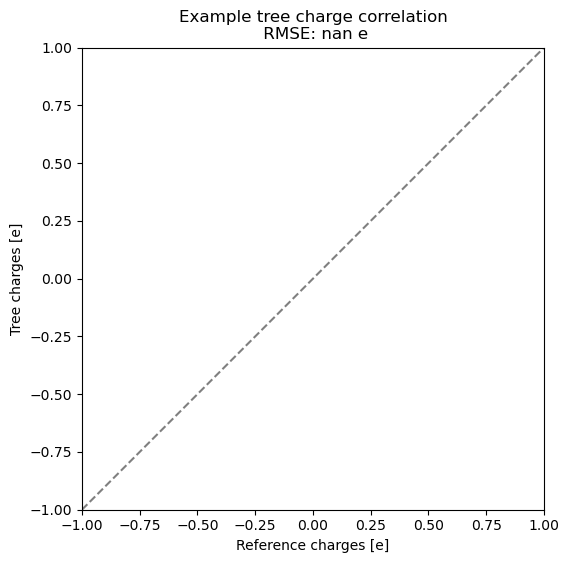

In [18]:
ax=df.plot.scatter(x="ref", y="tree", figsize=(6,6), xlim=(-1,1), ylim=(-1,1))
ax.set_aspect('equal')
ax.plot([-1,1],[-1,1], color="grey", linestyle="--")
ax.set_xlabel("Reference charges [e]")
ax.set_ylabel("Tree charges [e]")
ax.set_title(f"Example tree charge correlation\n RMSE: {np.sqrt(np.mean((df.tree-df.ref)**2)):.3f} e")

It can be seen, that even this very simple example tree can already assign partial charges with a decent accuracy. However, the small tree can not yet assign all molecules and with atoms with atom features not present in the training set the assigned charges will be NaN. In addition to the assigned charges we can also retrive the assignment path, the total attention values and the statistical errors.

## Test an example molecule with the example tree

In [19]:
example_mol = Chem.SDMolSupplier(sdf_suply, removeHs=False)[1]

In [20]:
partial_charge, path = example_tree.match_new_atom(1, example_mol)
path

cannot access local variable 'current_node' where it is not associated with a value


[root]

In [21]:
charges_in_path = []
counts_in_path = []
attention_in_path = []
stdDev_in_path = []
for node in path:
    charges_in_path.append(node.result)
    counts_in_path.append(node.count)
    attention_in_path.append(node.attention)
    stdDev_in_path.append(node.stdDeviation)

We can also observe, how the assigned partial charge slowly converges to the final value along the node path trough the tree. 

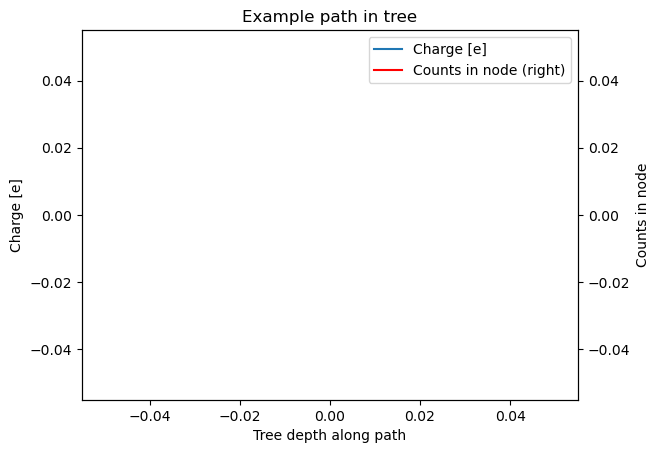

In [22]:
ax = pd.Series(charges_in_path).fillna(0).plot.line(label="Charge [e]")
ax2 = pd.Series(counts_in_path).plot.line(secondary_y=True, ax=ax, color="red", label="Counts in node")
ax.set_xlabel("Tree depth along path")
ax.set_ylabel("Charge [e]")
ax.set_title("Example path in tree")
ax.right_ax.set_ylabel("Counts in node")
ax.legend(handles=[ax.lines[0], ax2.lines[0]])

The above figure shows the number of counts decresing along the path through the tree, and going to 1, since our example dataset is so small, that we basically recover the full querry molecule. With a larger number of molecules in the dataset the averaging would be better, and we could use a certain attention value, collected along the path as stop marker for the matching to avoid overfitting.

Text(0.5, 1.0, 'Cumulative attention along path in the example tree')

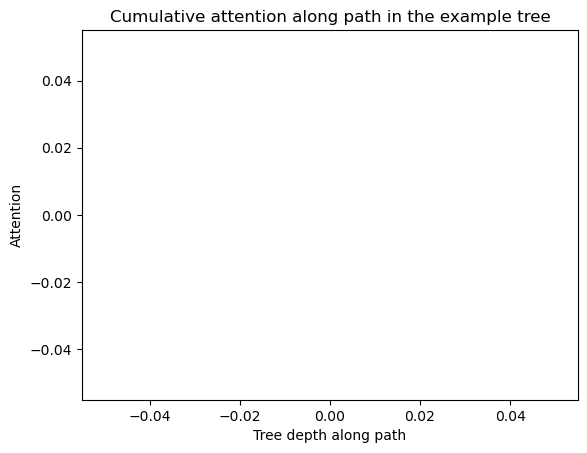

In [23]:
ax = pd.Series(attention_in_path).cumsum().fillna(0).plot.line(label="Attention")
ax.set_xlabel("Tree depth along path")
ax.set_ylabel("Attention")
ax.set_title("Cumulative attention along path in the example tree")

The threshold for the total attention can be tuned as meta parameter of the matching process in the tree.  

We can also plot the standard deviation in the nodes along the path, al;though it should be mentioned, that in a small example they are not very meaningfull.

Text(0.5, 1.0, 'StdDev along path in the example tree')

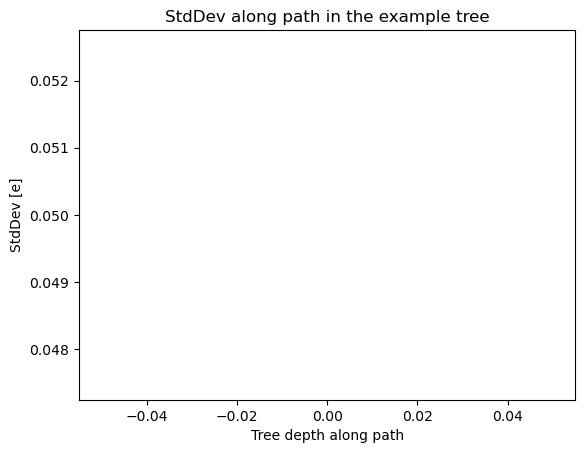

In [24]:
ax = pd.Series(stdDev_in_path).plot.line(label="StdDev [e]")
ax.set_xlabel("Tree depth along path")
ax.set_ylabel("StdDev [e]")
ax.set_title("StdDev along path in the example tree")

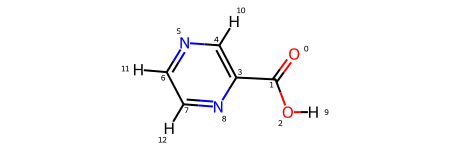

In [25]:
example_mol

In [26]:
for node in path[1:5]:
    af, idx, bond = node.atoms[0]
    print(f"af = {AtomFeatures.lookup_int(af)}, conncted to relative atom_idx = {idx}, with bond order = {bond}")

In [27]:
get_rdkit_fragment_from_node_path(path[1:6])

NameError: name 'get_rdkit_fragment_from_node_path' is not defined

In this case we selected the C atom of a carboxylic acid group and it can be seen, that this functional group is recovered in the path of the tree. The highest attention is on the double bond to the oxygen atom (atom 1 in the fragment), followed by the OH group (atom 2), the C atom (atom 3) and then the aromatic ring. This roughly corresponds to the chemical knowldge of a carboxylic acid group, but it is quantified by the attention values.

## Save the tree

The `Tree` class offers methods for file handling, allowing to save and load the tree from a file. This is useful, if the tree building process takes a long time and the tree needs to be build only once. The tree can then be loaded from the file and used for the assignment of partial charges. The files are human readable csv files, where each line coreesponds to a node in the tree.

In [ ]:
for num, child in enumerate(example_tree.root.children):
    child.to_file(f"{out_folder}/tree_{num}.csv")

The tree can then beloded, either from a single file, or from a folder with files for all branches of the tree.

In [ ]:
example_tree_2 = Tree()
example_tree_2.from_folder(out_folder)

In [ ]:
len(example_tree_2.root.children)

Clean up all the files created by this notebook

In [ ]:
rmtree(out_folder)